In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import sem, wilcoxon
from scipy.signal import medfilt

In [2]:
def smooth(a, kernel):
    b=np.convolve(a,kernel,'same')/np.convolve(np.ones(a.shape),kernel,'same')
    return b

In [3]:
vol_file = Path('analysis_sections_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system

sigma=60;
short_kernel=(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(np.arange(-sigma*3,sigma*3)**2)/(2*sigma**2))

In [4]:
def plot_subvolt(row, isplot=True):
    folder = row['folder']
    fish = row['fish']
    
    print(f'Processing {folder} {fish}')
    if row['task'][0] != 'R':
        return None
    
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.median(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')
    
    subvolt = dff.copy()
    smooth_spk = spk.copy()
    for n, ndff in enumerate(dff):
        subvolt[n, :] = medfilt(ndff, kernel_size=151)
        smooth_spk[n, :] = smooth(smooth_spk[n,:], short_kernel)
        
    delay_starts = frame_stimParams[2,:]==3
    delay_starts = np.where(np.diff(delay_starts.astype('int'))==1)[0]
    task_type = frame_stimParams[3,:][delay_starts]
    num_trial = len(delay_starts)
    num_t = 3000

    act_delay_sub = np.zeros((num_cell, num_t, num_trial))
    act_delay_spk = np.zeros((num_cell, num_t, num_trial))

    for n_delay in range(num_trial):
        delay_ = delay_starts[n_delay]
        act_delay_sub[:, :, n_delay] = subvolt[:, delay_:delay_+num_t] - subvolt[:, delay_-10:delay_+10].mean(axis=-1, keepdims=True)
        act_delay_spk[:, :, n_delay] = smooth_spk[:, delay_:delay_+num_t]

    rank_cell = np.zeros(num_cell)
    for n_cell in range(num_cell):
        mean_act_list = []
        for n_task_type in range(1, 4):
            mean_act_list.append(act_delay_sub[n_cell, :, task_type==n_task_type].mean(axis=0))
        _, pval1 = wilcoxon(mean_act_list[0], mean_act_list[1])
        _, pval2 = wilcoxon(mean_act_list[1], mean_act_list[2])
        sig1 = np.median(mean_act_list[0]-mean_act_list[1])
        sig2 = np.median(mean_act_list[1]-mean_act_list[2])        
        if np.sign(sig1) == np.sign(sig2) and pval1<0.05 and pval2<0.05:
            rank_cell[n_cell] = 1
        if isplot:
            print([sig1, pval1, sig2, pval2])
            fig, ax = plt.subplots(1, 2, figsize=(20, 4))
            for n_task_type in range(1,4):
                ax[0].plot(np.arange(num_t)/300, act_delay_sub[n_cell, :, task_type==n_task_type].mean(axis=0), label=f'{n_task_type}')
                ax[1].plot(np.arange(num_t)/300, act_delay_spk[n_cell, :, task_type==n_task_type].mean(axis=0)*300, label=f'{n_task_type}')
                # ax[1].plot(n_task_type, act_delay_spk[n_cell, :, task_type==n_task_type].mean()*300, 'o', label=f'{n_task_type}')
            ax[0].set_xlim([0, num_t/300])
            ax[0].set_xlabel('Time from delay onset (sec)')
            ax[0].set_ylabel('df/f')
            ax[1].set_xlim([0, num_t/300])
            ax[1].set_xlabel('Time from delay onset (sec)')
            ax[1].set_ylabel('Spike rate')
            plt.legend()
            plt.show()
    return rank_cell

Processing 03152018 Fish1-1
[0.003148657746533715, 0.0, -0.0072316931962689585, 0.0]


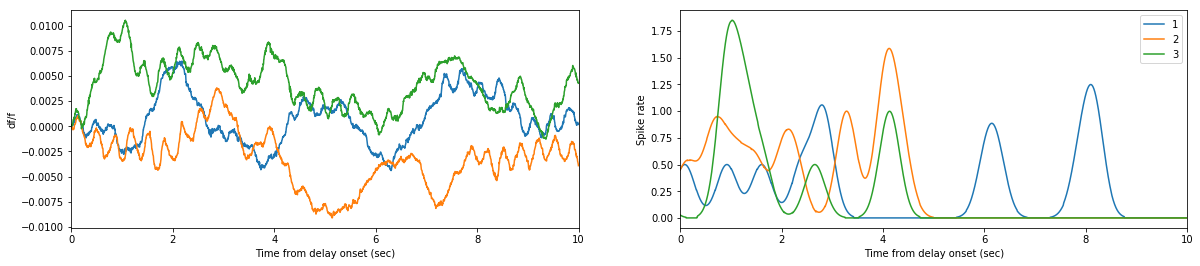

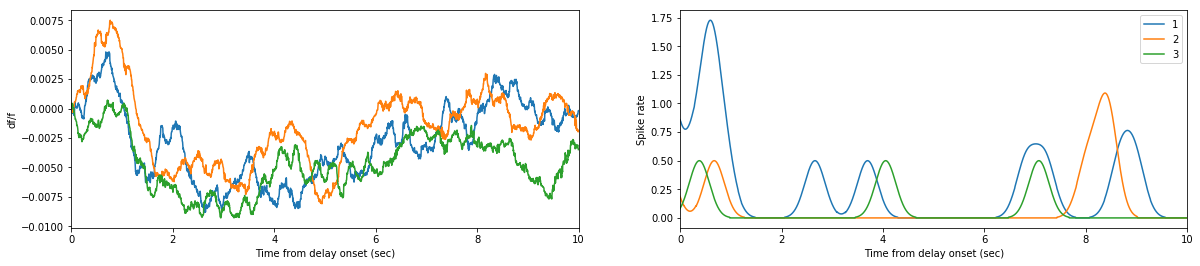

[-0.0016377203303571614, 1.428162162789424e-124, 0.0031512217803756804, 0.0]
[-1.9845340933192807e-06, 2.603175148548982e-05, -0.0025862411485249558, 0.0]


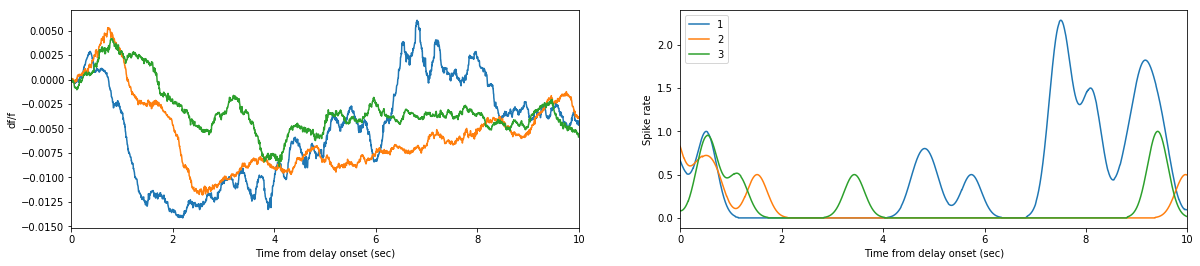

[0.005370701380635494, 0.0, -0.003131076473807219, 0.0]


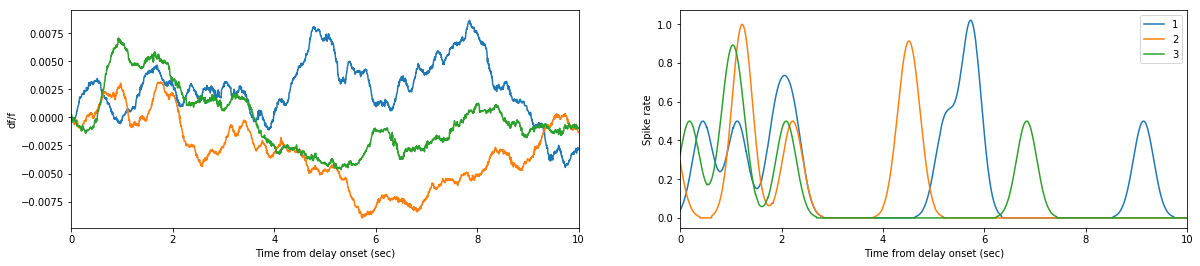

[0.00342983914588435, 0.0, 0.0027528469619429174, 2.3189679995645782e-270]


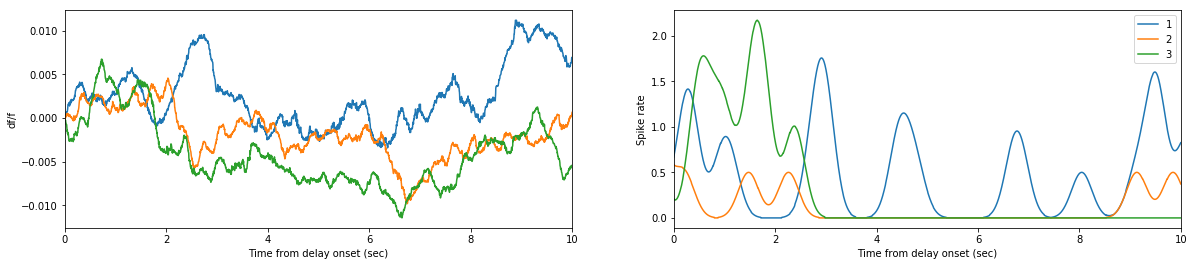

[0.0012100124472022638, 5.865501813251921e-50, 0.0012509261801065615, 3.3260571818664404e-21]


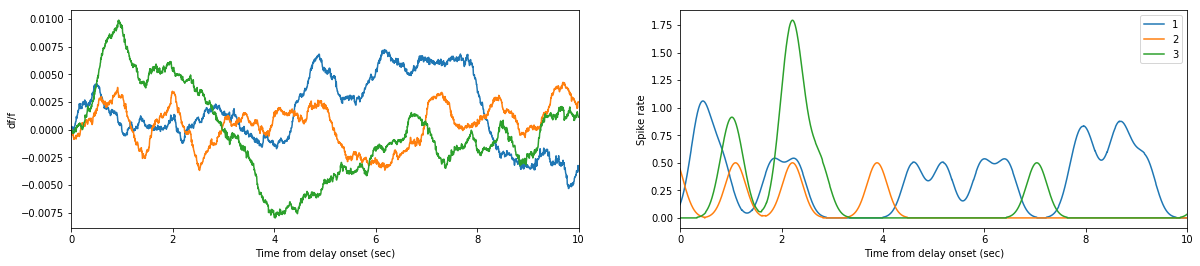

[0.0030437039601873828, 3.710326966088414e-190, -0.0013750872289459534, 7.881333764906388e-57]


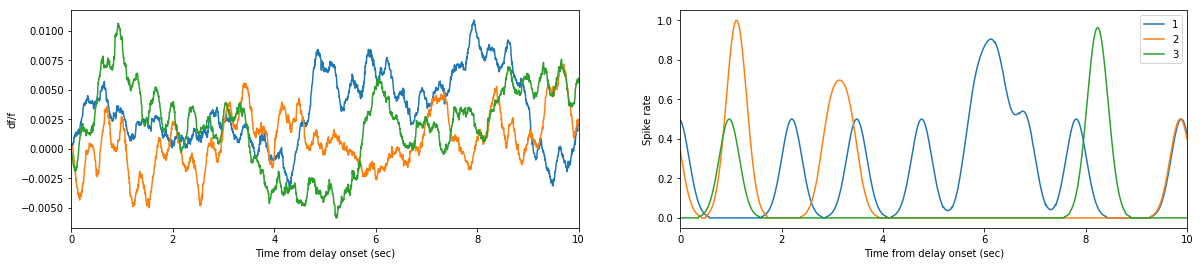

[0.0028534565033733507, 5.263943441096869e-224, -0.00649042290867418, 0.0]


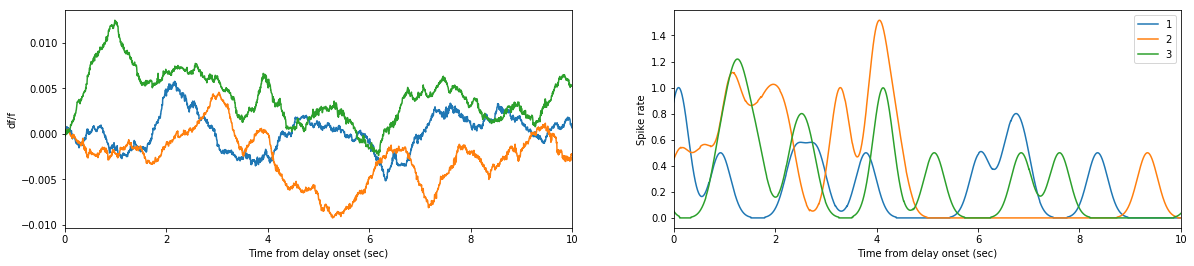

[0.0030647717207865927, 3.8386223666279093e-268, -0.00044109732623613294, 9.844100670528036e-27]


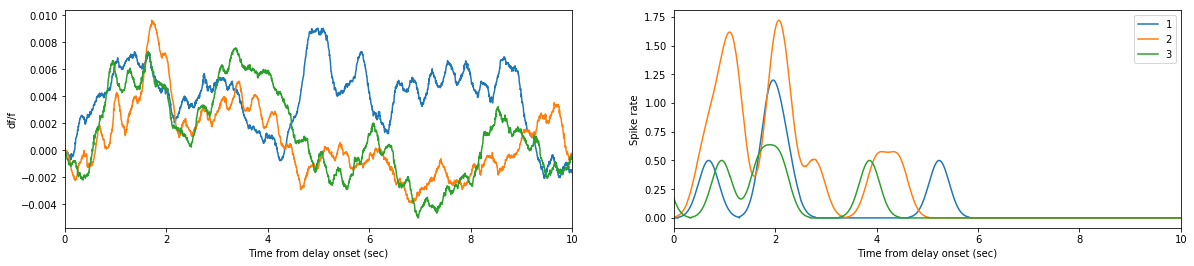

[0.00544240752693787, 0.0, -0.002707704655850282, 3.4762552438489733e-243]


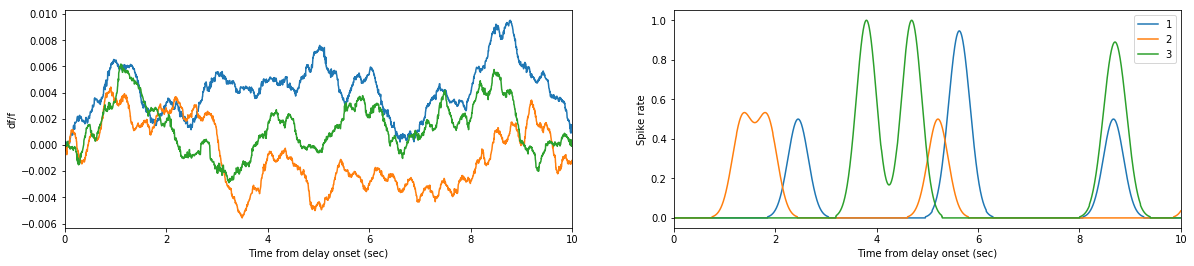

[0.005051740926203018, 1.0885245190491025e-267, -0.0028551123519086593, 0.0]


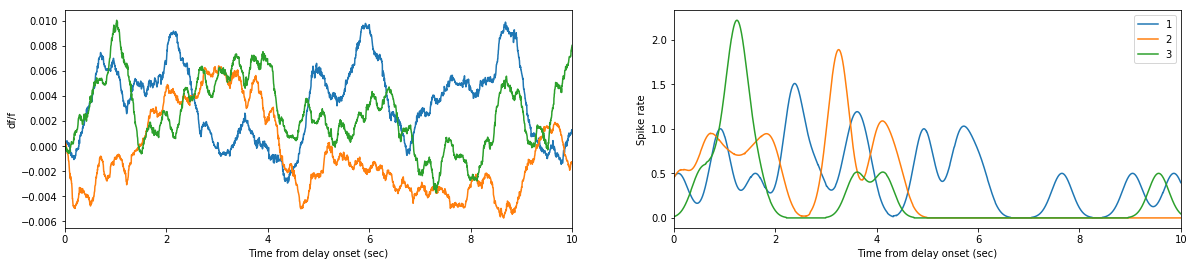

[0.0003399931865505825, 1.1215967727904484e-14, 0.0026870476960181066, 0.0]


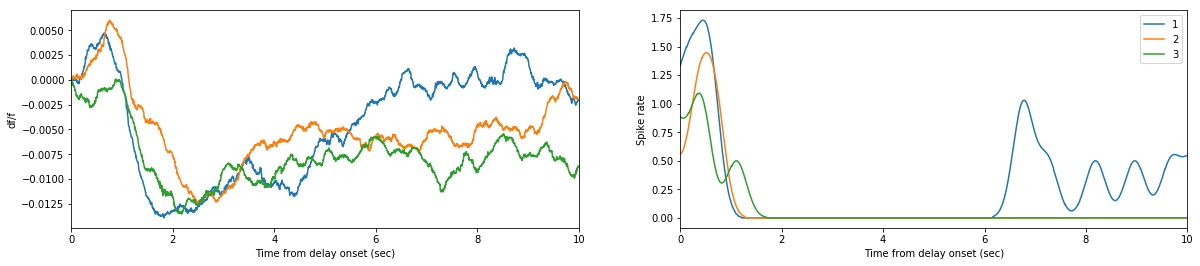

[-0.000763829595931703, 1.2755802879328155e-19, 0.001322682739779323, 5.313135969722944e-31]


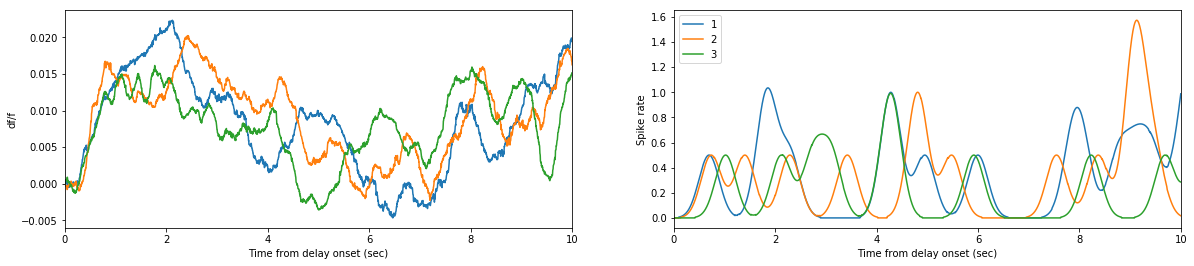

[0.0024300949987176297, 1.876963082817334e-196, 0.001008002620877839, 1.3614919380400221e-27]


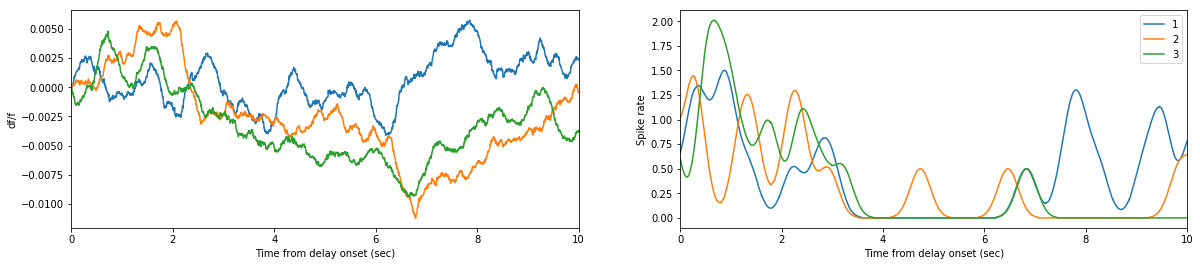

[0.003988447172153891, 0.0, -0.0008546690634423687, 8.8146442269111e-12]


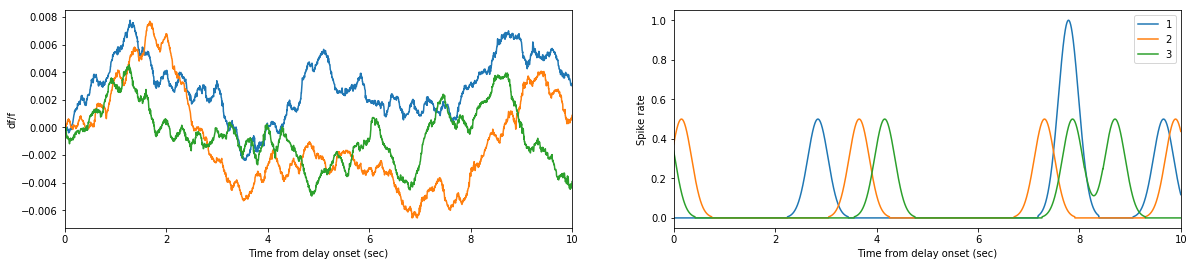

[-0.00042060204510223657, 7.25662254040388e-35, 0.00015727664802599184, 0.0007567628251261887]


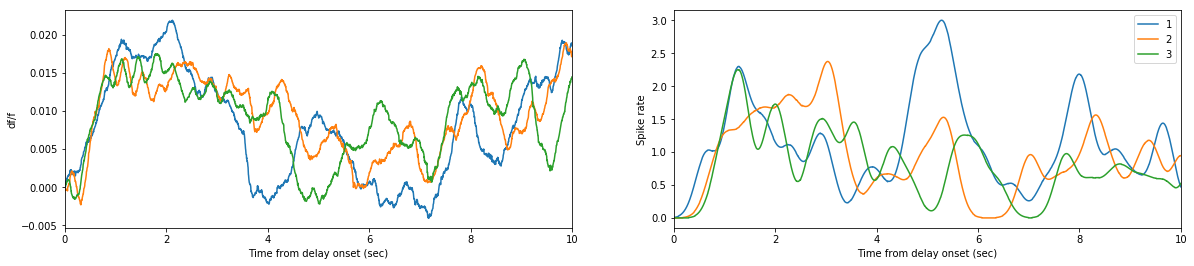

[0.002830856046869143, 2.4231834265952507e-259, -0.0025251598463428672, 0.0]


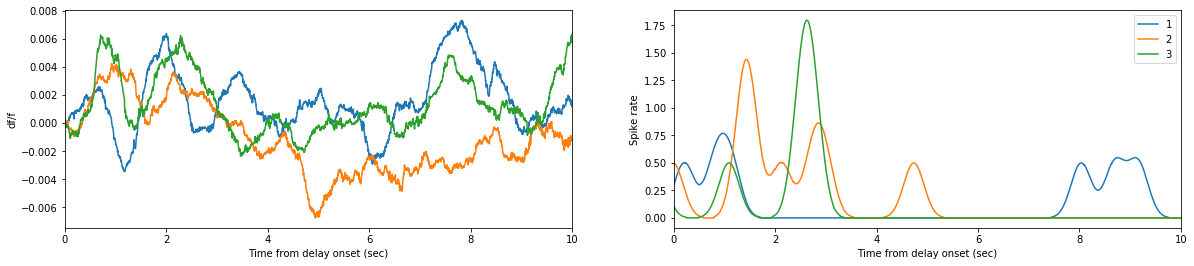

[0.003078823648656159, 2.802493396656644e-197, -5.721636329253821e-05, 0.01996066214725219]


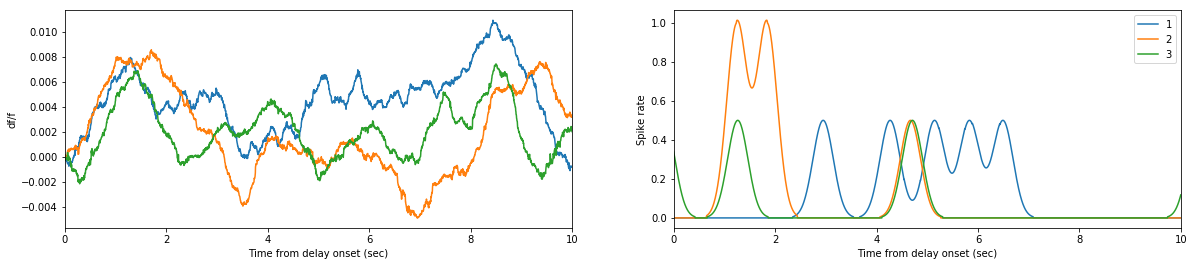

[0.0012338071702906377, 6.381487606817606e-77, -0.001876908409908779, 2.5378887509342735e-171]


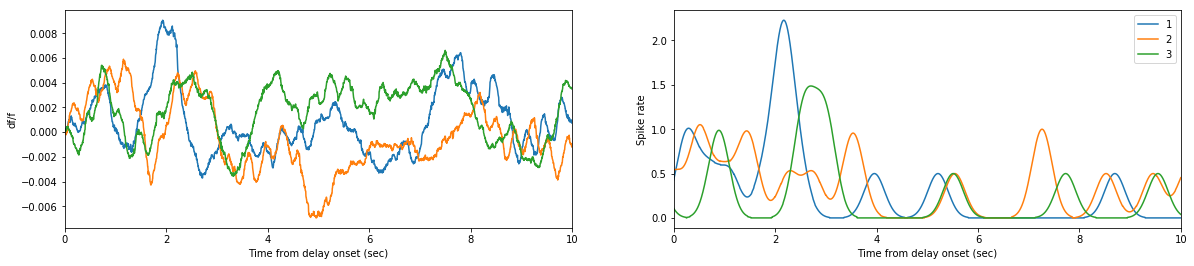

[0.003478247175113876, 0.0, 0.0019256534060100032, 0.004156749476493721]


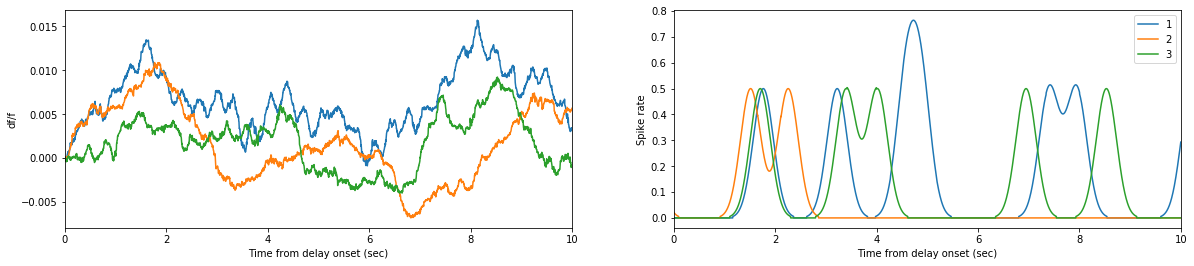

[0.004055921232792738, 0.0, -0.0022214486354518665, 5.648323244547085e-179]


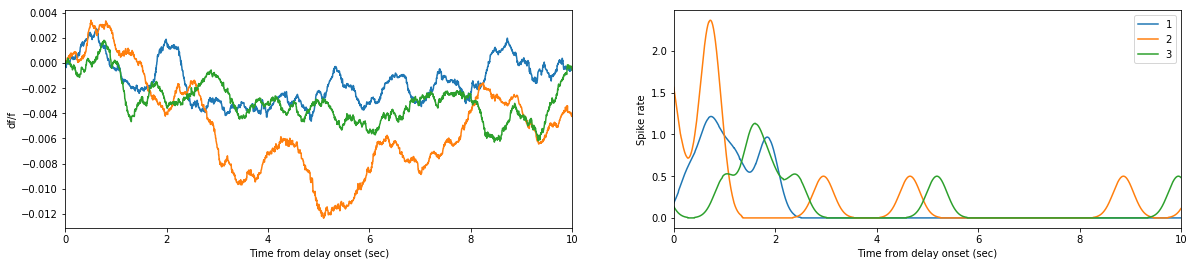

[0.0007598647672189198, 4.720200123734544e-41, -0.0013170787197304022, 7.588923505024362e-201]


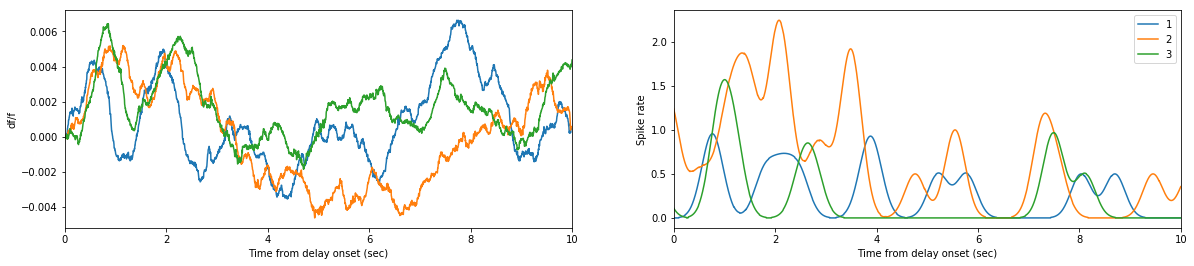

[0.00408928951538148, 0.0, -0.002136274315605707, 0.0]


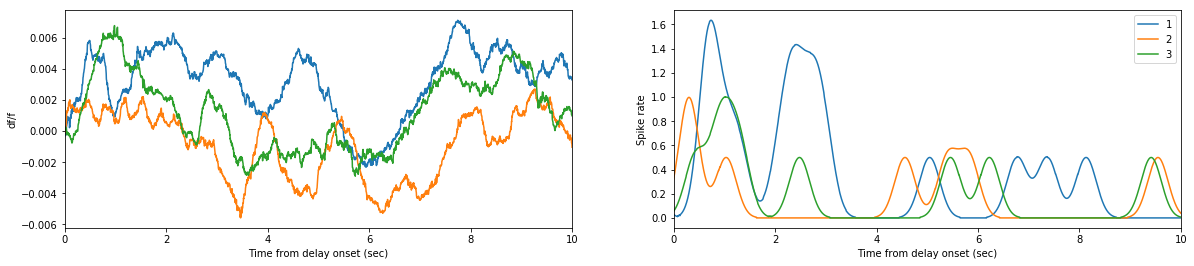

[0.00010106581896628098, 3.0753942400550414e-19, 0.0003158925513683966, 4.88558896395409e-12]


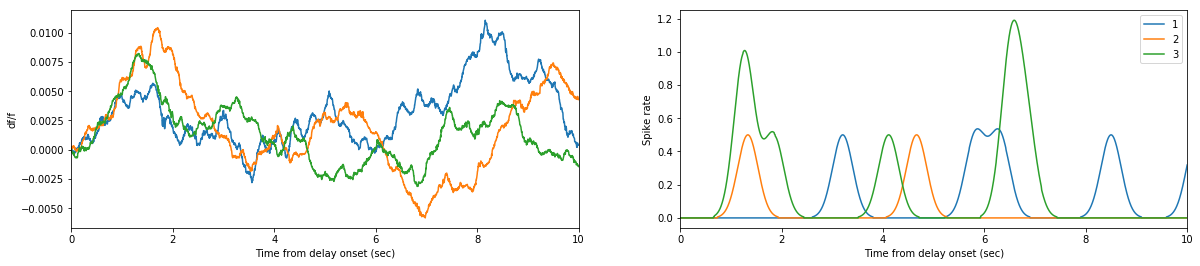

[0.00016625049874728474, 8.713797724403533e-05, -0.00015646269156129467, 3.746724923541501e-07]


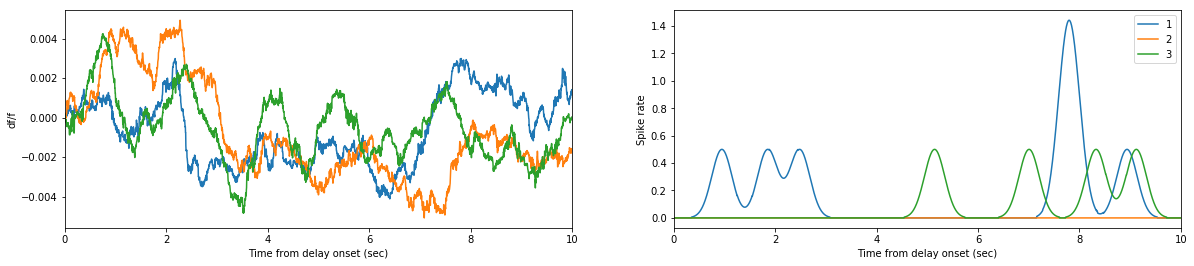

In [5]:
plot_subvolt(dat_xls_file.iloc[0], isplot=True);

In [ ]:
rank_cell_list = []
for index, row in dat_xls_file.iterrows():
    _ = plot_subvolt(row, isplot=False)
    if _ is not None:
        rank_cell_list.append(_)

Processing 03152018 Fish1-1
Processing 03152018 Fish4-1
Processing 03152018 Fish4-2
Processing 04052018 Fish4-1
Processing 04052018 Fish4-2
Processing 04122018 Fish2-1
Processing 04122018 Fish2-2
Processing 04122018 Fish4-1
Processing 04192018 Fish1-1
Processing 04192018 Fish1-2
Processing 04192018 Fish2-2


In [ ]:
rank_cell_list_flat = np.concatenate(rank_cell_list)

In [ ]:
rank_cell_list_flat.sum()

In [ ]:
len(rank_cell_list_flat)